<center><h1>Tibadiya_Prem_HW2</h1></center>
<br>
<br>

Name: Prem Mukeshkumar Tibadiya
<br>
Github Username: premtibadiyausc
<br>
USC ID: 6351-0184-40

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import math
from scipy import stats

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from patsy import dmatrices

Get the Cycle Power Plant Data Set

In [2]:
#dataframe = pd.read_excel('../content/Folds5x2_pp.xlsx')
dataframe = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx')
print(dataframe)

         AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]


### (b) Exploring the data

#### i. rows and columns

In [10]:
rows, column = dataframe.shape[0], dataframe.shape[1]
print("How many rows are in this data set?")
print("Rows count: ", rows)
print('\nHow many columns?')
print("Column count: ", column)
print("\nWhat do the rows and columns represent?")
print("Row: Each row contains a set of values that describe a single observation.")
print("Column: Each column contains a specific type of information about that observation.\n")


How many rows are in this data set?
Rows count:  9568

How many columns?
Column count:  5

What do the rows and columns represent?
Row: Each row contains a set of values that describe a single observation.
Column: Each column contains a specific type of information about that observation.



#### ii. pairwise scatterplots of all the varianbles

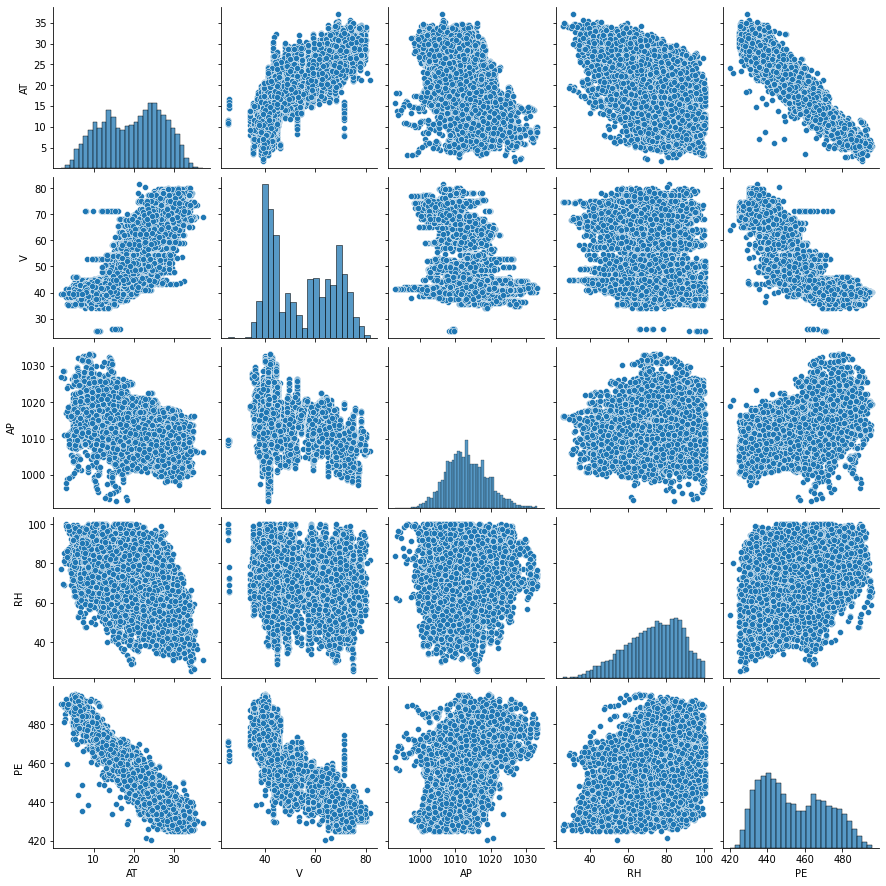

Describe your findings.
Few outliers are observed for every pair of variables

AT vs PE: Shows a strong, negative, linear association
V vs PE: Shows a strong, negative, linear association
AP vs PE: Shows a weak, positive, linear association and getting worse
RH vs PE: Shows a weak, positive, linear association and getting worse




In [14]:
sn.pairplot(dataframe)
plt.show()

print("Describe your findings.")
print("Few outliers are observed for every pair of variables\n")
print("AT vs PE: Shows a strong, negative, linear association")
print("V vs PE: Shows a strong, negative, linear association")
print("AP vs PE: Shows a weak, positive, linear association and getting worse")
print("RH vs PE: Shows a weak, positive, linear association and getting worse")
print("\n")

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [12]:
header = ['Variable','Mean','Median','Range','First Quartile','Third Quartile','IQR']
variables = list(dataframe.columns.values)
table = []
for v in variables:
    table.append([v, dataframe[v].mean(), dataframe[v].median(), dataframe[v].max() - dataframe[v].min(), dataframe[v].quantile(0.25), dataframe[v].quantile(0.75), dataframe[v].quantile(0.75) - dataframe[v].quantile(0.25)])
    
    
summary = pd.DataFrame(table, columns = header)
summary.style

,Variable,Mean,Median,Range,First Quartile,Third Quartile,IQR
0,AT,19.651231,20.345000,35.300000,13.510000,25.720000,12.210000
1,V,54.305804,52.080000,56.200000,41.740000,66.540000,24.800000
2,AP,1013.259078,1012.940000,40.410000,1009.100000,1017.260000,8.160000
3,RH,73.308978,74.975000,74.600000,63.327500,84.830000,21.502500
4,PE,454.365009,451.550000,75.500000,439.750000,468.430000,28.680000


### (c) Simple Linear Regression

OLS Summary: 
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 2.209e+04
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        03:56:46   Log-Likelihood:                -7406.8
No. Observations:                2392   AIC:                         1.482e+04
Df Residuals:                    2390   BIC:                         1.483e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.1683      0.308   161

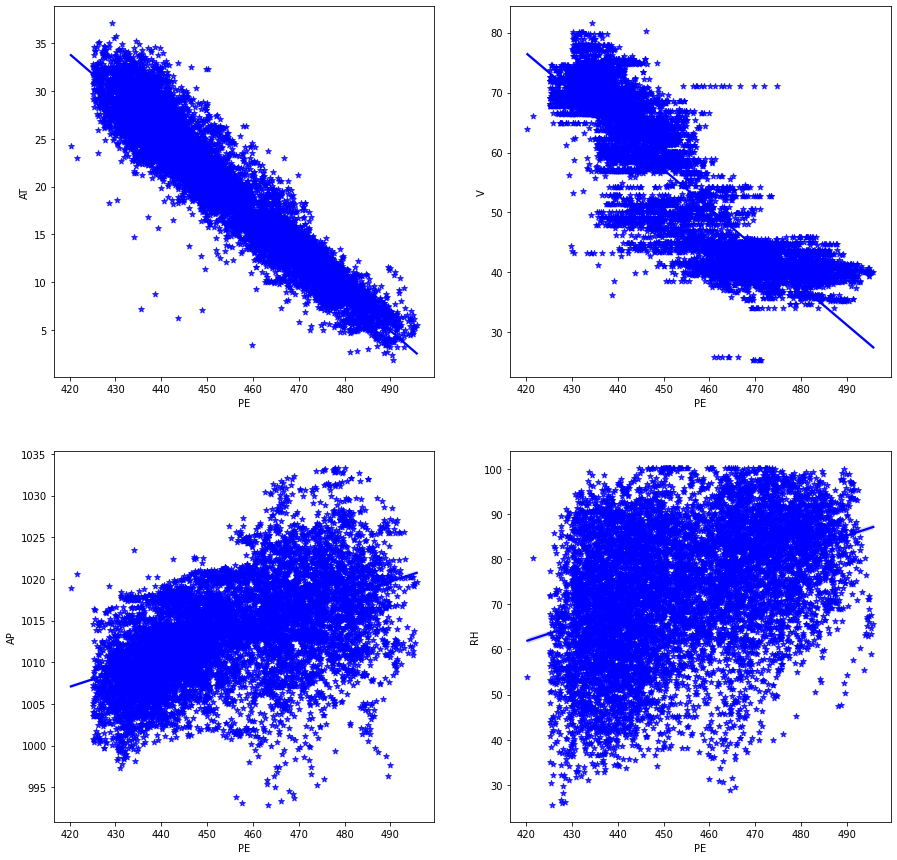

In [18]:
def fit_LR_Model(dataframe):
    
    predictors = list(dataframe.columns)[:-1]
    
    LR_coefficients = {}
    
    for p in predictors:
        
        # Split data into train and test sets
        trainX, testX, trainY, testY = train_test_split(dataframe[[p]], dataframe[['PE']], train_size = 0.75, random_state = 23)
        
        # Fit the model
        LR_model = LinearRegression().fit(trainX,trainY)
        
        # Model coefficients
        LR_coefficients[p] = LR_model.coef_
        
        # Y estimate 
        y_estimate = LR_model.predict(testX)
        
        testX = sm.add_constant(testX)
        
        summary = OLS(testY, testX).fit().summary()
        
        print("OLS Summary: ")
        print(summary)
        print('In which of the models is there a statistically significant association between the predictor and the response?')
        print("\n\nP values with all predictors are under 0.05 showing statistically significant relations")


    
    for k,v in LR_coefficients.items():
        if v < 0:
            print("\nStrong negative linear association in PE vs ", k)
        else:
            print("\nStrong positive linear association in PE vs ", k)
        
        
    print("\nPredictor vs Response Plots:\n")
    plot = plt.figure(figsize=(15,15))
    plot.subplots_adjust(hspace=0.2,wspace=0.2)
    
    for i in range(len(predictors)):
        plot.add_subplot(2, 2, i+1)
        sn.regplot(y = predictors[i], x = 'PE', data = dataframe, marker = '*', color = 'blue')
    
    return LR_coefficients


LR_coefficients = fit_LR_Model(dataframe)
print("Are there any outliers that you would like to remove from your data for each of these regression tasks?")
print("Yes, few outliers are found in all associations which would give a better result if removed")


### (d) Multiple Regression

In [21]:
def fit_MLR_Model(dataframe):
    
    MLR_coefficients = {}
    
    # Using design matrix to build Multi-LR model
    Y,X = dmatrices('PE ~ AT + V + AP + RH', dataframe)
    
    # Split data into train and test sets
    trainX, testX, trainY, testY = train_test_split(X, Y, random_state = 19, train_size = 0.8)
    
    trainY = pd.DataFrame(trainY)
    testY = pd.DataFrame(testY)
    
    trainX = pd.DataFrame(trainX)
    testX = pd.DataFrame(testX)
    
    trainX.columns = testX.columns = ['Intercept','AT','V','AP','RH']

    trainY.columns = testY.columns = ['PE']

    MLR_model = LinearRegression().fit(trainX,trainY)
    
    MLR_accuracy = MLR_model.score(testX, testY)
    
    MLR_summary = OLS(trainY, trainX).fit().summary()
    
    print("\nOLS Summary - Multi-LR Model:\n")
    print(MLR_summary)
    
    OLS_coefficients = OLS(trainY, trainX).fit().params
    
    # Storing MLR coefficients for later reference
    MLR_coefficients = {variables[i-1] : OLS_coefficients[i] for i in range(1, len(OLS_coefficients))}
    print('For which predictors can we reject the null hypothesis?')
    print("\nBased on the statistical analysis of the data, all of the predictors in the model have a significant relationship with the outcome variable, and the null hypothesis (which assumes that there is no relationship) can be rejected.")
    return MLR_coefficients, MLR_accuracy
    
    
MLR_coefficients, MLR_accuracy = fit_MLR_Model(dataframe)


OLS Summary - Multi-LR Model:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.530e+04
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        04:05:16   Log-Likelihood:                -22417.
No. Observations:                7654   AIC:                         4.484e+04
Df Residuals:                    7649   BIC:                         4.488e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    457.398

### (e) 1c Compare to 1d

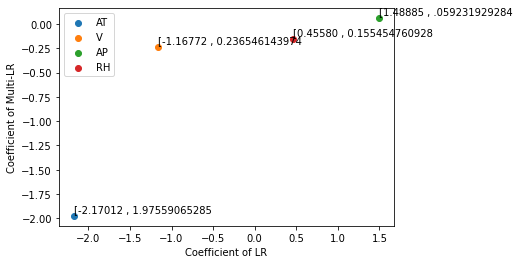

In [20]:
def compare(LR_coefficients, MLR_coefficients):
    
    plotData = []
    
    predictors = variables[:-1]
    
    for p in predictors:
        plotData.append([p, LR_coefficients[p][0][0], MLR_coefficients[p]])
    
    df_plotData = pd.DataFrame(plotData, columns = ['Predictor', 'LR Coefficients', 'Multi-LR Coefficients'])
    
    for v in predictors:
        
        pStr = str(LR_coefficients[v])[1:len(str(LR_coefficients[v])) - 5] + " , " + str(MLR_coefficients[v])[1:len(str(MLR_coefficients[v])) - 5]
        plt.scatter(LR_coefficients[v], MLR_coefficients[v], label = v)
        plt.annotate(pStr, (LR_coefficients[v], MLR_coefficients[v]), xytext = (LR_coefficients[v], MLR_coefficients[v] + 0.04))
    
    
    plt.xlabel("Coefficient of LR")
    plt.ylabel("Coefficient of Multi-LR")
    plt.legend()
    plt.show()
    
compare(LR_coefficients, MLR_coefficients)

### (f) Nonlinear Association

In [22]:
def fit_polynomial(dataframe):
    
    predictors = variables[:-1]
    
    for p in predictors:
        
        print("\n\nPolynomial Regression with Predictor: ", p)
        
        Y, X = dmatrices('PE ~ %s + I(%s ** 2) + I(%s ** 3)' % (p, p, p), dataframe)
        
        trainX, testX, trainY, testY = train_test_split(X, Y, random_state = 19, train_size = 0.8)
        
        trainX = pd.DataFrame(trainX)
        testX = pd.DataFrame(testX)
        
        trainY = pd.DataFrame(trainY)
        testY = pd.DataFrame(testY)
        
        trainX.column = testX.columns = ['intercept', p, p + '**2', p + '**3']
        
        testY.columns = trainY.columns = ['PE']
        
        OLS_model = OLS(trainY,trainX).fit()
        
        PolyR_model = LinearRegression()
        PolyR_model.fit(trainX, trainY)
        
        y_estimate = PolyR_model.predict(testX)
        
        summary = OLS_model.summary()
        
        print("OLS Summary:\n")
        print(summary)
        
    print("Is there evidence of nonlinear association between any of the predictors and the response?")
    print("The p-values for the variable V^2 are above the threshold of 0.05, indicating that it is not statistically significant. As a result, we can conclude that there is evidence of a non-linear relationship between the predictors and the response variable")
  
        
fit_polynomial(dataframe)



Polynomial Regression with Predictor:  AT
OLS Summary:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 2.705e+04
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        04:10:44   Log-Likelihood:                -23197.
No. Observations:                7654   AIC:                         4.640e+04
Df Residuals:                    7650   BIC:                         4.643e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

### (g) Interactions of Predictors

In [23]:
def predictors_Interaction(dataframe):
    
    Y, X = dmatrices('PE ~ AT + V + AP + RH + AT * V + AT * AP + AT * RH + V * AP + V * RH + AP * RH', dataframe)
    
    trainX, testX, trainY, testY = train_test_split(X,Y, random_state=19, train_size = 0.8)
    
    trainX = pd.DataFrame(trainX)
    testX = pd.DataFrame(testX)
    testY = pd.DataFrame(testY)
    trainY = pd.DataFrame(trainY)

    testX.columns = trainX.columns = ['Intercept','AT','V','AP','RH','AT vs V','AT vs AP','AT vs RH','V vs AP','V vs RH','AP vs RH']
    
    trainY.columns = testY.columns = ['PE']

    Full_LR_model = LinearRegression()
    
    Full_LR_model.fit(trainX, trainY)
    
    y_estimate = Full_LR_model.predict(testX)
    
    accuracy = Full_LR_model.score(testX, testY)
    
    print("\nOLS Summary:\n")
    
    print(OLS(trainY, trainX).fit().summary())
    print("Is there evidence of association of interactions of predictors with the response?")
    print("\nEvidence Found. Following interaction terms are statistically significant:")
    
    print("\n1)AT - V \n2)AT - RH \n3)V - AP")
    
    
predictors_Interaction(dataframe)


OLS Summary:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.150e+04
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        04:12:55   Log-Likelihood:                -21958.
No. Observations:                7654   AIC:                         4.394e+04
Df Residuals:                    7643   BIC:                         4.401e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    676.7073     87.038     

### (h) Improvement

In [24]:
def R_model(dataframe, formula, predictors):
    
    Y, X = dmatrices(formula, dataframe)
    trainX, testX, trainY, testY = train_test_split(X, Y, random_state=19, train_size=0.7)
    trainX = pd.DataFrame(trainX)
    testX = pd.DataFrame(testX)
    trainY = pd.DataFrame(trainY)
    testY = pd.DataFrame(testY)
    testX.columns = trainX.columns = predictors
    testY.columns = trainY.columns = ['PE'] 
    model = LinearRegression().fit(trainX, trainY)    
    y_estimate_test = model.predict(testX)   
    y_estimate_train = model.predict(trainX)   
    mse_train = mean_squared_error(y_estimate_train, trainY)
    mse_test = mean_squared_error(y_estimate_test, testY)    
    print(OLS(trainY, trainX).fit().summary())
    return mse_train, mse_test

mse_train, mse_test = R_model(dataframe, 'PE ~ AT + V + AP + RH', ['Intercept','AT','V','AP','RH'])
print("\n\nMean Squared Errors in Regression Model from from all possible interaction terms: ")
print("\nTrain MSE: ", mse_train)
print("Test MSE: ", mse_test, "\n")

mse_train, mse_test = R_model(dataframe, 'PE ~ AT + V + AP + RH + (AT * V) + (AT * AP) + (AT * RH) + (V * AP) + (V * RH) + (AP * RH) + I(AT ** 2) + I(V ** 2) + I(AP ** 2) + I(RH ** 2)', ['Intercept','AT','V','AP','RH','AT vs V','AT vs AP','AT vs RH','V vs AP','V vs RH','AP vs RH','I(AT ** 2)','I(V ** 2)','I(AP ** 2)','I(RH ** 2)'])
print("\n\nMean Squared Errors in Regression Model from all possible interaction terms and quadratic nonlinearities: ")
print("\nTrain MSE: ", mse_train)
print("Test MSE: ", mse_test, "\n")

mse_train, mse_test = R_model(dataframe, 'PE ~ AP + RH + (AT:V) + (AT:RH) + (AP:RH) + I(AT ** 2) + I(AP ** 2) + I(RH ** 2)', ['Intercept','AP','RH','AT vs V','AT vs RH','AP vs RH','I(AT ** 2)','I(AP ** 2)','I(RH ** 2)'])
print("\n\nMean squared errors of Regression model from statistically significant terms: ")
print("\nTrain MSE: ", mse_train)
print("Test MSE: ", mse_test, "\n")


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 2.213e+04
Date:                Sat, 11 Feb 2023   Prob (F-statistic):               0.00
Time:                        04:13:25   Log-Likelihood:                -19644.
No. Observations:                6697   AIC:                         3.930e+04
Df Residuals:                    6692   BIC:                         3.933e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    450.8435     11.577     38.942      0.0

### (i) KNN

KNN using normalized data:
K value giving us the Best Fit:  4 
Max accuracy:  99.71462633800404


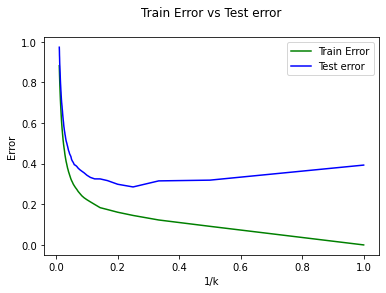



KNN using raw data:
K value giving us the Best Fit:  6 
Max accuracy:  94.26450074199235


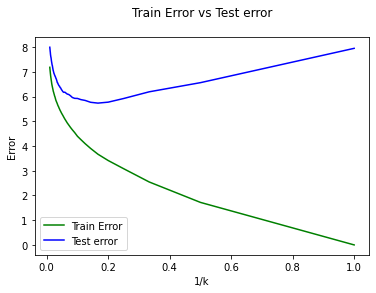

In [25]:
def KNN(dataframe, isNormalized):

    if isNormalized:
        predictors = variables
        best_k = 1
    else:
        predictors = variables[:-1]
        best_k = 0
        
    k_range = np.arange(1, 101, 1)
    
    max_acc = 0
    
    
    error_train = np.empty([100])
    error_test = np.empty([100])
    
    X = dataframe[predictors]
    Y = dataframe['PE']
    
    trainX, testX, trainY, testY = train_test_split(X, Y, random_state=19, train_size=0.8)
    
    for i in range(len(k_range)):
        
        KNN_model = KNeighborsRegressor(n_neighbors = k_range[i], weights = 'uniform', p = 2, algorithm = 'auto')
        
        KNN_model.fit(trainX, trainY)
        
        y_estimate_test = KNN_model.predict(testX)
        
        # not for raw
        y_estimate_train = KNN_model.predict(trainX)
        
        accuracy = KNN_model.score(testX, testY)
        
        error_train[i] = (1 - KNN_model.score(trainX, trainY)) * 100
        
        error_test[i] = (1 - KNN_model.score(testX, testY)) * 100
        
        if(accuracy > max_acc):
            
            max_acc = accuracy
            
            best_k = k_range[i]
            
    print("K value giving us the Best Fit: ", best_k, "\nMax accuracy: ", max_acc * 100)
    
    terms_k = [1/k for k in range(1,101,1)]

    plt.title("Train Error vs Test error\n")
    
    plt.plot(terms_k, error_train, label='Train Error', color='green')
    
    plt.plot(terms_k, error_test, label='Test error', color='blue')
    
    plt.xlabel('1/k')

    plt.ylabel('Error')
    
    plt.legend()
    
    plt.show()
    
    return max_acc
        
    

df_normalised = preprocessing.normalize(dataframe)
df_normalised = pd.DataFrame(df_normalised)
df_normalised.columns = variables

print("KNN using normalized data:")
max_acc_norm = KNN(df_normalised, True)
print("\n\nKNN using raw data:")
max_acc_raw = KNN(dataframe, False)

### (j ) Compare KNN and Linear

In [26]:
# ANALYSIS
# Compare the results of KNN Regression with the linear regression model that has the smallest test error.

# Best Linear Regression Model vs KNN (Normalized Data)

print("Accuracy of Multiple Linear regression: ",(MLR_accuracy)*100)
print("Accuracy of KNN Normalized: ",(max_acc_norm)*100)
print("\nLeast Test error for Multiple Linear regression: ",(1 - MLR_accuracy)*100)
print("Least Test error for KNN Normalized: ",(1 - max_acc_norm)*100)
print("\nConclusion: KNN Regression (Normalized version) performed better than linear regression models")

Accuracy of Multiple Linear regression:  92.44551216317834
Accuracy of KNN Normalized:  99.71462633800404

Least Test error for Multiple Linear regression:  7.554487836821666
Least Test error for KNN Normalized:  0.28537366199595793

Conclusion: KNN Regression (Normalized version) performed better than linear regression models


## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

**Better**

We have a sufficient amount of data available for each predictor. Because we have a large number of sample points, using a more flexible statistical learning method would result in a better fit to the data and better performance compared to a less flexible approach.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

**Worse**

In this case, we do not have sufficient data available to estimate the outcome and variance for each attribute. To perform parameter analysis, we need to draw a larger number of sample points than the number of parameters. Using a more flexible modeling approach would result in overfitting the model, as there are fewer sample points available.


### (c) The relationship between the predictors and response is highly non-linear.

**Better**

In this case, a more flexible modeling approach would be able to fit the data better, because it has more degrees of freedom than a less flexible approach, which is more constrained in its ability to fit the data.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

**Worse**

A more flexible modeling approach would incorporate the noise and errors in the data, which would increase the variance of the model. As a result, the model may be underfit, which means that it may not be able to capture the true underlying relationships in the data.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

In [33]:
obs1 = math.dist([0, 3, 0], [0, 0, 0])
obs2 = math.dist([2, 0, 0], [0, 0, 0])
obs3 = math.dist([0, 1, 3], [0, 0, 0])
obs4 = math.dist([0, 1, 2], [0, 0, 0])
obs5 = math.dist([-1, 0, 1], [0, 0, 0])
obs6 = math.dist([1, 1, 1], [0, 0, 0])

print("Euclidean Distance for observation-1 =", obs1)
print("Euclidean Distance for observation-2 =", obs2)
print("Euclidean Distance for observation-3 =", obs3)
print("Euclidean Distance for observation-4 =", obs4)
print("Euclidean Distance for observation-5 =", obs5)
print("Euclidean Distance for observation-6 =", obs6)

Euclidean Distance for observation-1 = 3.0
Euclidean Distance for observation-2 = 2.0
Euclidean Distance for observation-3 = 3.1622776601683795
Euclidean Distance for observation-4 = 2.23606797749979
Euclidean Distance for observation-5 = 1.4142135623730951
Euclidean Distance for observation-6 = 1.7320508075688772


### (b) What is our prediction with K = 1? Why?

Our prediction is "Green" as the closest neighbour is 5 which is green.

### (c) What is our prediction with K = 3? Why?

Our prediction is "Red" by majority as the closest neighbour is 5,6 and 2 with Y values Green, Red and Red repectively.

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

Prefered K value would be small as the k value increases the boundary becomes inflexible.